<a href="https://colab.research.google.com/github/MATVEN/machine-learning/blob/main/Progetto_Un_modello_di_previsione_per_il_mercato_immobiliare.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Introduzione

##**Un modello di previsione per il mercato immobiliare**
RealEstateAI Solutions si propone di ottimizzare la valutazione dei prezzi immobiliari attraverso l'uso di tecniche avanzate di regolarizzazione in modelli di regressione lineare. L'obiettivo è fornire previsioni di prezzo più accurate e affidabili, riducendo il rischio di overfitting e migliorando la capacità di generalizzazione del modello.

Nel settore immobiliare, ottenere stime precise dei prezzi delle proprietà è cruciale per prendere decisioni informate. Tuttavia, i modelli di regressione lineare tradizionali possono soffrire di overfitting, compromettendo l'accuratezza delle previsioni. È necessario esplorare metodi di regolarizzazione efficaci per migliorare le performance predittive e gestire la complessità del modello.

Implementando e confrontando metodi di regolarizzazione come Lasso, Ridge e Elastic Net, RealEstateAI Solutions offrirà un sistema in grado di fornire previsioni di prezzo immobiliari più accurate e stabili. Questo permetterà agli agenti immobiliari e agli investitori di prendere decisioni basate su dati più affidabili, aumentando la loro competitività nel mercato.

####**Requisiti del Progetto**:

1. **Preparazione del Dataset**:
 * Caricamento e preprocessamento dei dati sui prezzi immobiliari.
 * Gestione dei valori mancanti, codifica delle variabili categoriche e normalizzazione/scalatura dei dati.

2. **Implementazione dei Modelli di Regressione**:
 * Ridge Regression: Implementazione e addestramento del modello con regolarizzazione Ridge.
 * Lasso Regression: Implementazione e addestramento del modello con regolarizzazione Lasso.
 * Elastic Net Regression: Implementazione e addestramento del modello con regolarizzazione Elastic Net.
3. **Valutazione delle Performance**:
 * Utilizzo di tecniche di validazione incrociata.
 * Calcolo del Mean Squared Error (MSE) per ciascun modello.
 * Confronto della complessità dei modelli valutando il numero di coefficienti non nulli.
 * Analisi e confronto dei risultati dei vari metodi di regolarizzazione.
4. **Visualizzazione dei Risultati**:
 * Creazione di grafici per visualizzare e confrontare le performance dei modelli.
 * Visualizzazione della distribuzione dei residui per valutare l'adeguatezza del modello.
 * Visualizzazione dell'andamento dei coefficienti dei modelli rispetto ai parametri di regolarizzazione.

Il progetto deve includere il codice sorgente completo, con commenti dettagliati che spiegano i vari passaggi, le scelte fatte e i risultati ottenuti, per garantire trasparenza e replicabilità del lavoro.



##Il Dataset

* **Price**: il prezzo, il target da prevedere
* **Area**: superficie dell’immobile
* **Bedrooms**: numero di camere da letto
* **Bathrooms**: numero di bagni
* **Stories**: numero di piani
* **Mainroad**: vale 1 se l’immobile affaccia su una strada principale, 0 altrimenti
* **guestroom**: vale 1 se l’immobile ha una stanza degli ospiti, 0 altrimenti
* **basement**: vale 1 se l’immobile ha un seminterrato, 0 altrimenti
* **hotwaterheating**: vale 1 se l’immobile ha una caldaia, 0 altrimenti
* **airconditioning**: vale 1 se l’immobile ha l’aria condizionata, 0 altrimenti
* **parking**: numero di parcheggi
* **prefarea**: vale 1 se l’immobile è in una zona prestigiosa, 0 altrimenti
* **Furnishingstatus**: vale 0 se l’immobile non è arredato, 1 se è parzialmente arredato, 2 se è completamente arredato


#Progetto

##Preparazione dei Dati

###Librerie e Moduli

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_validate, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

###Funzioni

In [ ]:
def remove_outliers(df, column, threshold=0.99):
    upper_limit = df[column].quantile(threshold)
    return df[df[column] < upper_limit]


def train_and_evaluate_model(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    mse = mean_squared_error(y_test, predictions)
    mae = mean_absolute_error(y_test, predictions)
    r2 = r2_score(y_test, predictions)
    return mse, predictions


def cross_val_detailed(model, X, y):
    cv_results = cross_validate(model, X, y, scoring='neg_mean_squared_error', cv=5, return_train_score=True)
    mse_scores = -cv_results['test_score']
    return mse_scores

def print_categorical_summary(df, categorical_vars):
    for var in categorical_vars:
        counts = df[var].value_counts()
        print(f"Distribuzione di {var}:")
        for category, count in counts.items():
            print(f"{category}: {count}")
        print("\n")

def calcola_statistiche_modello(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    return {
        'MSE': mse,
        'RMSE': rmse,
        'MAE': mae,
        'R²': r2
    }



def evaluate_model_over_alphas(model_class, alphas, X_train, y_train, X_test, y_test, **model_kwargs):
    mse_values = []
    for alpha in alphas:
        model = model_class(alpha=alpha, **model_kwargs)
        mse, _ = train_and_evaluate_model(model, X_train, y_train, X_test, y_test)
        mse_values.append(mse)
    return mse_values

# Funzione coefficienti per ciascun modello
def get_coefficients(model_class, alphas, X_train, y_train, model_name, **kwargs):
    model_class_name = model_class.__name__
    coefs = []

    for alpha in alphas:
        model = model_class(alpha=alpha, **kwargs)
        model.fit(X_train, y_train)
        coefs.append(model.coef_)

    return coefs

# Funzione per calcolare l'MSE in funzione di alpha per ciascun modello
def compute_mse_vs_alpha(model_class, alphas, X_train, y_train, X_test, y_test, **kwargs):
    mse_values = []
    for alpha in alphas:
        model = model_class(alpha=alpha, **kwargs)
        model.fit(X_train, y_train)
        mse = mean_squared_error(y_test, model.predict(X_test))
        mse_values.append(mse)
    return mse_values

# Funzione per visualizzare i coefficienti in funzione di alpha
def plot_coefficients(alphas, coefs, feature_names, title):
    plt.figure(figsize=(14, 6))
    for i, feature_name in enumerate(feature_names):
        plt.plot(alphas, [coef[i] for coef in coefs], label=feature_name)
    plt.xscale('log')
    plt.xlabel('Alpha')
    plt.ylabel('Coefficienti')
    plt.title(title)
    plt.legend(loc='upper right')
    plt.grid(True)
    plt.show()

# Funzione per stampare i risultati degli MSE
def print_mse_results(alphas, ridge_mse, lasso_mse, elasticnet_mse):
    print(f"{'Alpha':<25}{'Ridge MSE':<25}{'Lasso MSE':<25}{'Elastic Net MSE':<25}")
    print("="*100)
    for alpha, ridge, lasso, elasticnet in zip(alphas, ridge_mse, lasso_mse, elasticnet_mse):
        print(f"{alpha:<25.6f}{ridge:<25.6f}{lasso:<25.6f}{elasticnet:<25.6f}")

###Dataset

In [ ]:
DATASET_URL = "https://proai-datasets.s3.eu-west-3.amazonaws.com/housing.csv"

In [ ]:
df = pd.read_csv(DATASET_URL)
df.head(10)

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,13300000,7420,4,2,3,1,0,0,0,1,2,1,1
1,12250000,8960,4,4,4,1,0,0,0,1,3,0,1
2,12250000,9960,3,2,2,1,0,1,0,0,2,1,2
3,12215000,7500,4,2,2,1,0,1,0,1,3,1,1
4,11410000,7420,4,1,2,1,1,1,0,1,2,0,1
5,10850000,7500,3,3,1,1,0,1,0,1,2,1,2
6,10150000,8580,4,3,4,1,0,0,0,1,2,1,2
7,10150000,16200,5,3,2,1,0,0,0,0,0,0,0
8,9870000,8100,4,1,2,1,1,1,0,1,2,1,1
9,9800000,5750,3,2,4,1,1,0,0,1,1,1,0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 545 entries, 0 to 544
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   price             545 non-null    int64
 1   area              545 non-null    int64
 2   bedrooms          545 non-null    int64
 3   bathrooms         545 non-null    int64
 4   stories           545 non-null    int64
 5   mainroad          545 non-null    int64
 6   guestroom         545 non-null    int64
 7   basement          545 non-null    int64
 8   hotwaterheating   545 non-null    int64
 9   airconditioning   545 non-null    int64
 10  parking           545 non-null    int64
 11  prefarea          545 non-null    int64
 12  furnishingstatus  545 non-null    int64
dtypes: int64(13)
memory usage: 55.5 KB


In [ ]:
df.describe()

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
count,5.450000e+02,545.000000,545.000000,545.000000,545.000000,545.000000,545.000000,545.000000,545.000000,545.000000,545.000000,545.000000,545.000000
mean,4.766729e+06,5150.541284,2.965138,1.286239,1.805505,0.858716,0.177982,0.350459,0.045872,0.315596,0.693578,0.234862,1.089908
std,1.870440e+06,2170.141023,0.738064,0.502470,0.867492,0.348635,0.382849,0.477552,0.209399,0.465180,0.861586,0.424302,0.858130
min,1.750000e+06,1650.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.430000e+06,3600.000000,2.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,4.340000e+06,4600.000000,3.000000,1.000000,2.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,5.740000e+06,6360.000000,3.000000,2.000000,2.000000,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000,2.000000
max,1.330000e+07,16200.000000,6.000000,4.000000,4.000000,1.000000,1.000000,1.000000,1.000000,1.000000,3.000000,1.000000,2.000000


###Preprocessing

####Pulizia Dataset

In [ ]:
for column in df.columns:
    if df[column].dtype == 'object':
        df[column].fillna(df[column].mode()[0], inplace=True)
    else:
        df[column].fillna(df[column].mean(), inplace=True)

df.head(10)

<ipython-input-70-24950e17d46d>:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[column].fillna(df[column].mean(), inplace=True)


,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,13300000,7420,4,2,3,1,0,0,0,1,2,1,1
1,12250000,8960,4,4,4,1,0,0,0,1,3,0,1
2,12250000,9960,3,2,2,1,0,1,0,0,2,1,2
3,12215000,7500,4,2,2,1,0,1,0,1,3,1,1
4,11410000,7420,4,1,2,1,1,1,0,1,2,0,1
5,10850000,7500,3,3,1,1,0,1,0,1,2,1,2
6,10150000,8580,4,3,4,1,0,0,0,1,2,1,2
7,10150000,16200,5,3,2,1,0,0,0,0,0,0,0
8,9870000,8100,4,1,2,1,1,1,0,1,2,1,1
9,9800000,5750,3,2,4,1,1,0,0,1,1,1,0


####Normalizzazione Separata Variabili Binari e Continue

In [ ]:
# Rimozione di outliers su price
df = remove_outliers(df, 'price', threshold=0.99)

# Trasformazione della variabile area, se asimmetrica
df['area_log'] = np.log(df['area'] + 1)

<ipython-input-71-f3d1b2cb726d>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['area_log'] = np.log(df['area'] + 1)


In [ ]:
# Separazione variabili binarie - variabili numeriche
binary_columns = ['mainroad', 'guestroom', 'basement', 'hotwaterheating', 'airconditioning', 'prefarea']
numeric_columns = ['area', 'bedrooms', 'bathrooms', 'stories', 'parking', 'furnishingstatus']

In [ ]:
scaler = StandardScaler()
X_binary = df[binary_columns]
X_numeric_scaled = scaler.fit_transform(df[numeric_columns])
X_numeric_scaled = pd.DataFrame(X_numeric_scaled, columns=numeric_columns)

In [ ]:
X_processed = pd.concat([X_binary.reset_index(drop=True), X_numeric_scaled.reset_index(drop=True)], axis=1)
y = np.log(df['price'] + 1)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_processed, y, test_size=0.2, random_state=42)
print("Dataset preprocessato e diviso in set di addestramento e test.")

Dataset preprocessato e diviso in set di addestramento e test.


###Analisi Esplorativa dei Dati

####Distribuzione della variabile target 'Price'

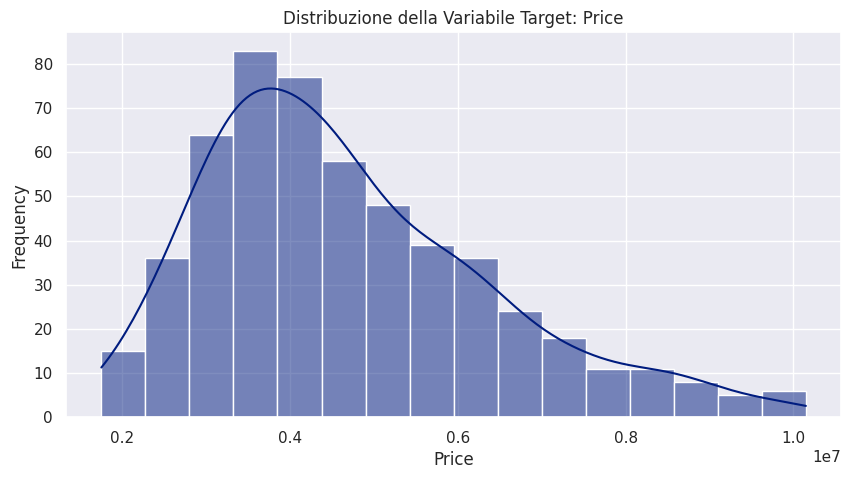

In [ ]:
plt.figure(figsize=(10, 5))
sns.histplot(df['price'], kde=True)
plt.title('Distribuzione della Variabile Target: Price')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.show()

In [ ]:
price_mean = df['price'].mean()
price_median = df['price'].median()
price_std = df['price'].std()
price_min = df['price'].min()
price_max = df['price'].max()
price_quantiles = df['price'].quantile([0.25, 0.5, 0.75])

print(f"Distribuzione della Variabile Target: Price\n")
print(f"Media: {price_mean:.2f}")
print(f"Mediana: {price_median:.2f}")
print(f"Deviazione Standard: {price_std:.2f}")
print(f"Minimo: {price_min}")
print(f"Massimo: {price_max}")
print(f"Quantili:")
print(price_quantiles)

Distribuzione della Variabile Target: Price

Media: 4685700.26
Mediana: 4319000.00
Deviazione Standard: 1712754.40
Minimo: 1750000
Massimo: 10150000
Quantili:
0.25    3430000.0
0.50    4319000.0
0.75    5696250.0
Name: price, dtype: float64


I dati relativi ai prezzi mostrano una distribuzione che suggerisce una certa asimmetria positiva, indicata dal fatto che la media (4685700.26) è superiore alla mediana (4319000.00). Questo potrebbe indicare la presenza di immobili con prezzi più elevati che aumentano la media rispetto alla mediana, rendendo la distribuzione leggermente skewed verso destra.

La deviazione standard è di 1712754.40, evidenziando una significativa variabilità nei prezzi immobiliari, probabilmente dovuta a fattori quali ubicazione, dimensioni e caratteristiche specifiche degli immobili.

I valori minimi e massimi, rispettivamente di 1750000 e 10150000, confermano un'ampia gamma di valori nella variabile target, coprendo sia fasce di prezzo più economiche che di lusso.

I quantili (25º, 50º e 75º percentile) mostrano una graduale progressione: il 25% degli immobili è al di sotto di $3,430,000, mentre il 75% è sotto i 5696,250. Ciò indica una distribuzione dei prezzi concentrata in una fascia relativamente ampia, ma comunque dominata da valori centrali e medio-alti.



####Matrice di correlazione

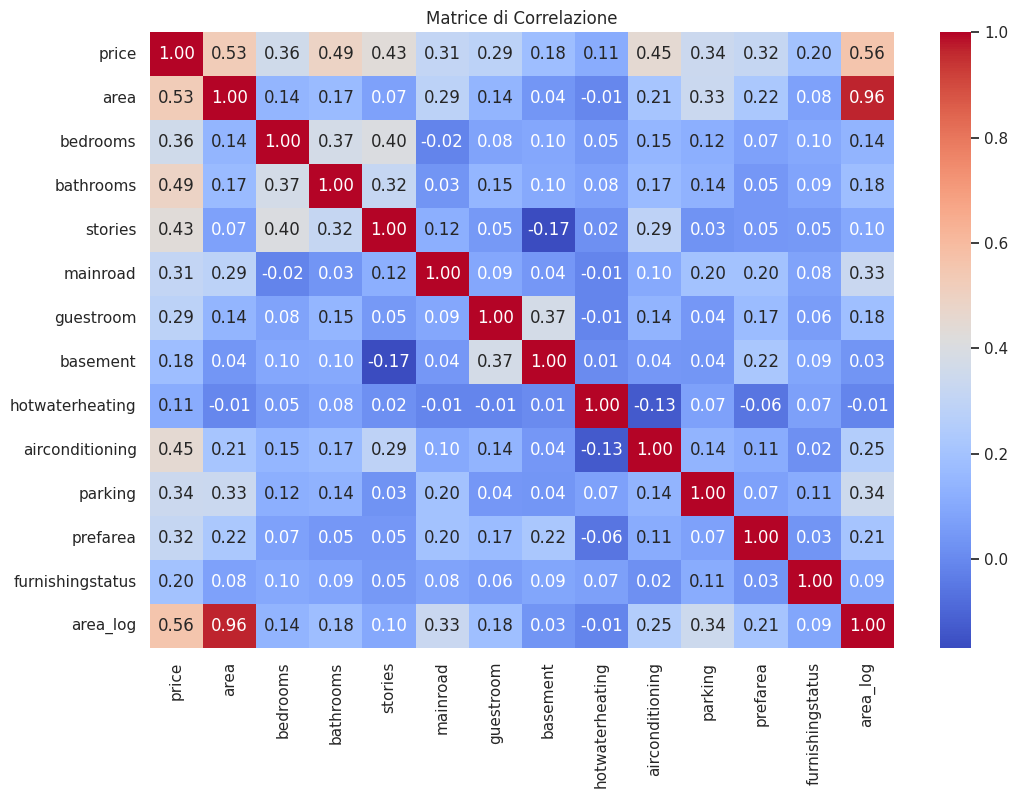

In [ ]:
plt.figure(figsize=(12, 8))
correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title('Matrice di Correlazione')
plt.show()

La matrice evidenzia correlazioni chiave tra il prezzo (***price***) e altre variabili.

* **Principali correlazioni con il prezzo**: area_log (0.56) e area (0.53) mostrano le correlazioni più forti con il prezzo, suggerendo che la dimensione dell’immobile è un fattore cruciale. Anche bathrooms (0.49) e airconditioning (0.45) sono moderatamente correlati, indicando che bagni e aria condizionata incidono positivamente sul valore dell’immobile.

* **Correlazioni secondarie**: Variabili come bedrooms (0.36), stories (0.43) e mainroad (0.31) hanno correlazioni più deboli, ma contribuiscono comunque al prezzo. La presenza di una guestroom ha una correlazione modesta (0.29).

* **Variabili con minore influenza**: hotwaterheating (0.11) e basement (0.18) mostrano correlazioni molto basse, indicando un impatto limitato sul prezzo.

* **Relazioni tra variabili:** La trasformazione logaritmica di area (area_log) è altamente correlata con area (0.96), mentre guestroom e basement (0.37) sono moderatamente associati tra loro, suggerendo una tendenza delle proprietà con cantina a includere anche una stanza per gli ospiti.

Questo quadro mostra quali variabili influenzano maggiormente il prezzo, aiutando a selezionare le caratteristiche più significative per i modelli di regressione.

####Scatter plot variabili numeriche vs 'Price'

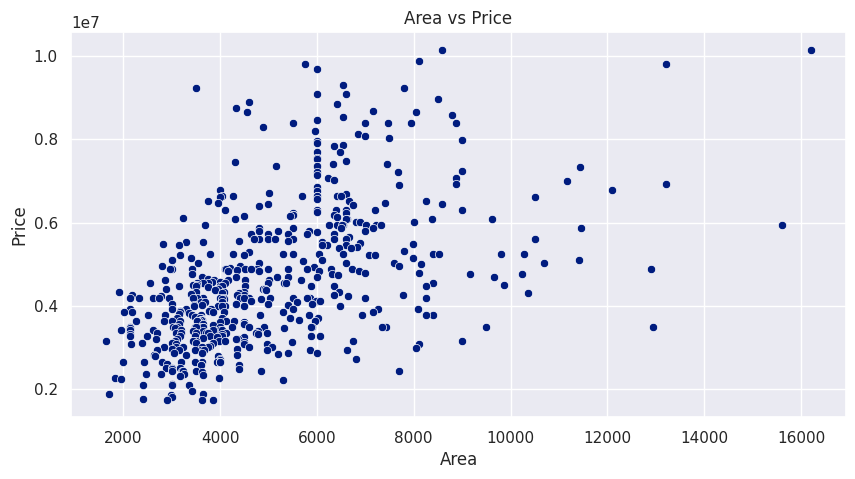

In [ ]:
plt.figure(figsize=(10, 5))
sns.scatterplot(x=df['area'], y=df['price'])
plt.title('Area vs Price')
plt.xlabel('Area')
plt.ylabel('Price')
plt.show()

Il grafico mostra una relazione positiva tra l'area degli immobili e il loro prezzo. La tendenza generale suggerisce che all'aumentare dell'area il prezzo tende a salire, ma la presenza di una notevole dispersione indica che non tutti i punti seguono perfettamente questa relazione.

La distribuzione dei punti suggerisce che l'area è un fattore rilevante per determinare il prezzo, ma la variabilità osservata nel grafico lascia intuire l'influenza di altre variabili. In particolare, gli outlier con prezzi particolarmente elevati o aree estremamente grandi possono influire sul pattern generale.

In sintesi, il grafico evidenzia una relazione positiva, sebbene non perfettamente lineare, tra area e prezzo, sottolineando l'importanza di considerare ulteriori fattori per comprendere appieno le dinamiche del mercato immobiliare.

####Distribuzione delle variabili categoriche

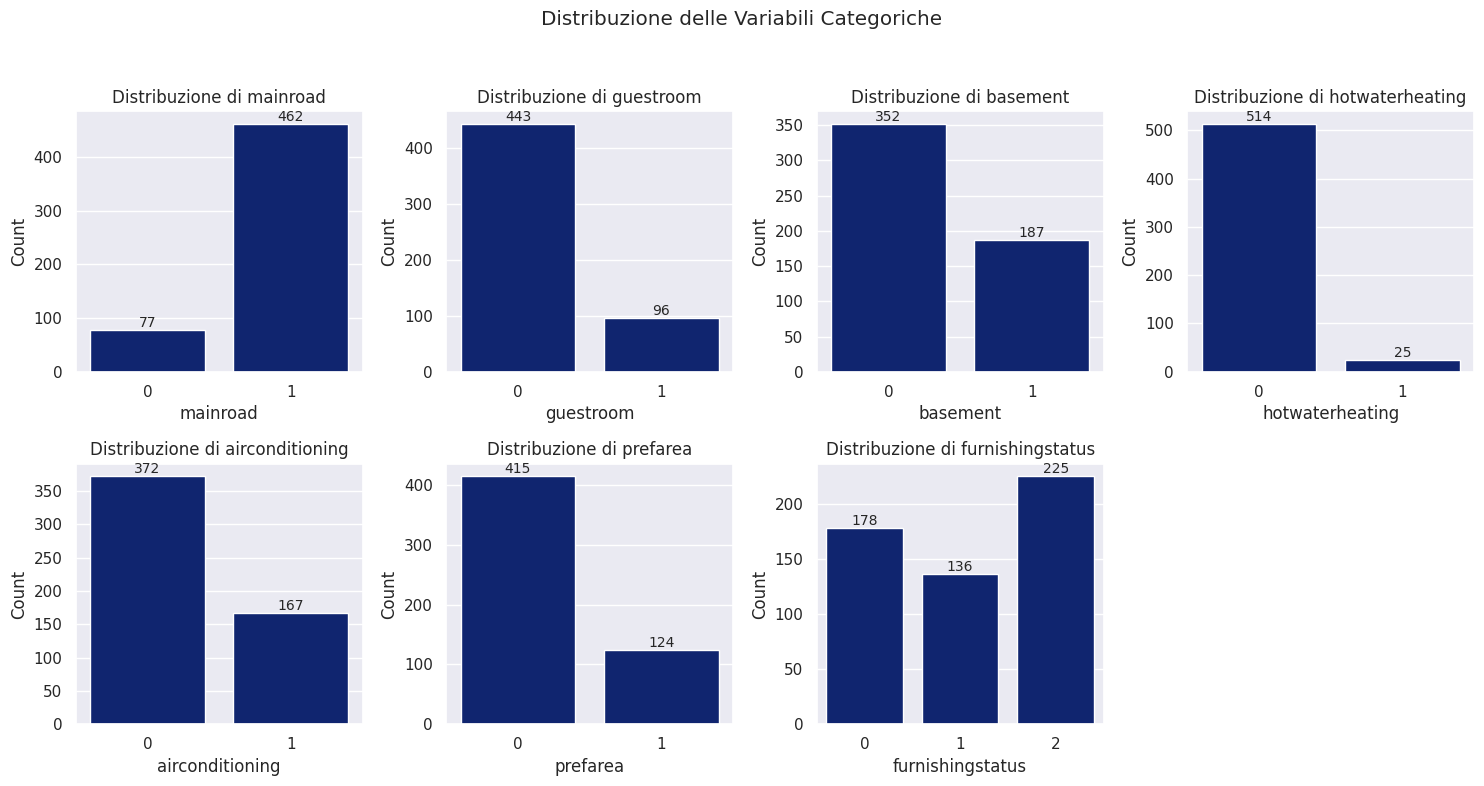

In [ ]:
categorical_vars = ['mainroad', 'guestroom', 'basement', 'hotwaterheating',
                    'airconditioning', 'prefarea', 'furnishingstatus']

fig, axes = plt.subplots(2, 4, figsize=(15, 8))
fig.suptitle('Distribuzione delle Variabili Categoriche')

axes = axes.flatten()

for i, var in enumerate(categorical_vars):
    ax = axes[i]
    plot = sns.countplot(x=df[var], ax=ax)
    ax.set_title(f'Distribuzione di {var}')
    ax.set_xlabel(var)
    ax.set_ylabel('Count')

    for p in plot.patches:
        count = int(p.get_height())
        if count > 0:
            ax.annotate(f'{count}',
                        (p.get_x() + p.get_width() / 2., count),
                        ha='center', va='bottom', fontsize=10)

# Rimuovi l'ultimo asse vuoto
for j in range(len(categorical_vars), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

Analisi delle Variabili Categoriali

La distribuzione delle variabili categoriali evidenzia le caratteristiche più comuni e meno comuni degli immobili nel dataset:

1. **Mainroad**: La maggior parte degli immobili (462) si trova vicino a una strada principale, rispetto a 77 che non lo sono, suggerendo che la vicinanza alla strada principale è una caratteristica prevalente.

2. **Guestroom**: Solo 96 immobili dispongono di una stanza per gli ospiti, contro 443 che non ne hanno, indicando che le stanze per gli ospiti sono relativamente rare.

3. **Basement**: 187 immobili hanno una cantina, mentre 352 ne sono sprovvisti, facendo della cantina una caratteristica meno comune ma presente in una parte significativa del campione.

4. **Hotwaterheating**: Il riscaldamento ad acqua calda è estremamente raro, presente solo in 25 immobili su 539.

5. **Airconditioning**: L’aria condizionata è più comune, presente in 167 immobili, ma la maggioranza (372) ne è priva.

6. **Prefarea**: 124 immobili sono situati in aree preferenziali, mentre 415 non lo sono, suggerendo che queste aree sono selezionate meno frequentemente.

7. **Furnishingstatus**: Gli immobili sono distribuiti tra stati di arredamento diversi: 225 sono completamente arredati, 178 non arredati e 136 semi-arredati, mostrando una leggera preferenza per immobili arredati.

Questa distribuzione delle caratteristiche fornisce un quadro della composizione del dataset, utile per valutare l’impatto di queste variabili nei modelli di previsione del prezzo.

##Implementazione dei Modelli di Regressione

In [ ]:
# Crezione istanze dei modelli con regolarizzazione
ridge_model = Ridge(alpha=1.0)
lasso_model = Lasso(alpha=1.0)
elasticnet_model = ElasticNet(alpha=1.0, l1_ratio=0.5)

In [ ]:
# Addestramento e valutazione di ogni modello
ridge_mse, ridge_predictions = train_and_evaluate_model(ridge_model, X_train, y_train, X_test, y_test)
lasso_mse, lasso_predictions = train_and_evaluate_model(lasso_model, X_train, y_train, X_test, y_test)
elasticnet_mse, elasticnet_predictions = train_and_evaluate_model(elasticnet_model, X_train, y_train, X_test, y_test)

##Valutazione delle Performance

In [ ]:
# Confronto delle performance
print(f"Ridge MSE: {ridge_mse}")
print(f"Lasso MSE: {lasso_mse}")
print(f"Elastic Net MSE: {elasticnet_mse}")

Ridge MSE: 0.046326805284181025
Lasso MSE: 0.1669174083960979
Elastic Net MSE: 0.1669174083960979


I risultati mostrano che il modello **Ridge** ha ottenuto il valore di **MSE più basso (0.046)**, indicando una maggiore capacità predittiva rispetto agli altri modelli. Al contrario, i modelli **Lasso** ed **Elastic Net** hanno prodotto valori di **MSE identici (0.167)**, suggerendo una performance simile tra loro, ma inferiore rispetto a Ridge. Questo suggerisce che la regolarizzazione **Ridge** è più efficace nel gestire il dataset in questo contesto.

In [ ]:
mse_results = {
    "Ridge": ridge_mse,
    "Lasso": lasso_mse,
    "Elastic Net": elasticnet_mse
}
best_model = min(mse_results, key=mse_results.get)
print(f"Il modello con il MSE più basso è: {best_model}")

Il modello con il MSE più basso è: Ridge


In [ ]:
# Validazione incrociata dettagliata per ciascun modello
ridge_mse_scores = cross_val_detailed(ridge_model, X_train, y_train)
lasso_mse_scores = cross_val_detailed(lasso_model, X_train, y_train)
elasticnet_mse_scores = cross_val_detailed(elasticnet_model, X_train, y_train)

In [ ]:
# Calcolo MSE medio con Cross-Validation
ridge_mse_cv = np.mean(ridge_mse_scores)
ridge_mse_cv_std = np.std(ridge_mse_scores)
lasso_mse_cv = np.mean(lasso_mse_scores)
lasso_mse_cv_std = np.std(lasso_mse_scores)
elasticnet_mse_cv = np.mean(elasticnet_mse_scores)
elasticnet_mse_cv_std = np.std(elasticnet_mse_scores)

print(f"Ridge MSE (CV): {ridge_mse_cv:.2f} ± {ridge_mse_cv_std}")
print(f"Lasso MSE (CV): {lasso_mse_cv:.2f} ± {lasso_mse_cv_std}")
print(f"Elastic Net MSE (CV): {elasticnet_mse_cv:.2f} ± {elasticnet_mse_cv_std}")

Ridge MSE (CV): 0.04 ± 0.009583619154970224
Lasso MSE (CV): 0.12 ± 0.01816139182996838
Elastic Net MSE (CV): 0.12 ± 0.01816139182996838


I risultati della Cross-Validation evidenziano che il modello **Ridge** ottiene il **MSE medio più basso (0.04 ± 0.0096)**, dimostrando sia una maggiore accuratezza predittiva che una variabilità ridotta rispetto agli altri modelli. I modelli **Lasso** ed **Elastic Net** presentano un **MSE medio simile (0.12 ± 0.0182)**, con una variabilità leggermente superiore rispetto a **Ridge**. Questi risultati confermano la superiorità di **Ridge** nel bilanciare errore e stabilità in questo dataset.

In [ ]:
# Numero di coefficienti non nulli per ciascun modello
ridge_non_zero = np.sum(ridge_model.coef_ != 0)
lasso_non_zero = np.sum(lasso_model.coef_ != 0)
elasticnet_non_zero = np.sum(elasticnet_model.coef_ != 0)

In [ ]:
print(f"Numero di coefficienti non nulli - Ridge: {ridge_non_zero}")
print(f"Numero di coefficienti non nulli - Lasso: {lasso_non_zero}")
print(f"Numero di coefficienti non nulli - Elastic Net: {elasticnet_non_zero}")

Numero di coefficienti non nulli - Ridge: 12
Numero di coefficienti non nulli - Lasso: 0
Numero di coefficienti non nulli - Elastic Net: 0


Il modello **Ridge** utilizza tutti i **12 coefficienti**, mantenendo tutte le variabili predittive nel modello. Al contrario, i modelli **Lasso** ed **Elastic Net** hanno azzerato tutti i coefficienti, eliminando ogni contributo delle variabili predittive. Questo comportamento evidenzia che Lasso ed Elastic Net applicano una regolarizzazione molto aggressiva, probabilmente a causa di un valore elevato del parametro di regolarizzazione, rendendoli inefficaci nel catturare le relazioni con il target in questo caso specifico. Ridge si dimostra più robusto, preservando le informazioni utili.

##Visualizzazione dei Risultati

###Performance

In [ ]:
# Lista degli MSE medi dai risultati della validazione incrociata
model_names = ['Ridge', 'Lasso', 'Elastic Net']

mse_means = [ridge_mse_cv, lasso_mse_cv, elasticnet_mse_cv]
mse_stds = [ridge_mse_scores.std(), lasso_mse_scores.std(), elasticnet_mse_scores.std()]

model_scores = [ridge_mse_scores, lasso_mse_scores, elasticnet_mse_scores]

####Confronto MSE Medio con Cross-Validation

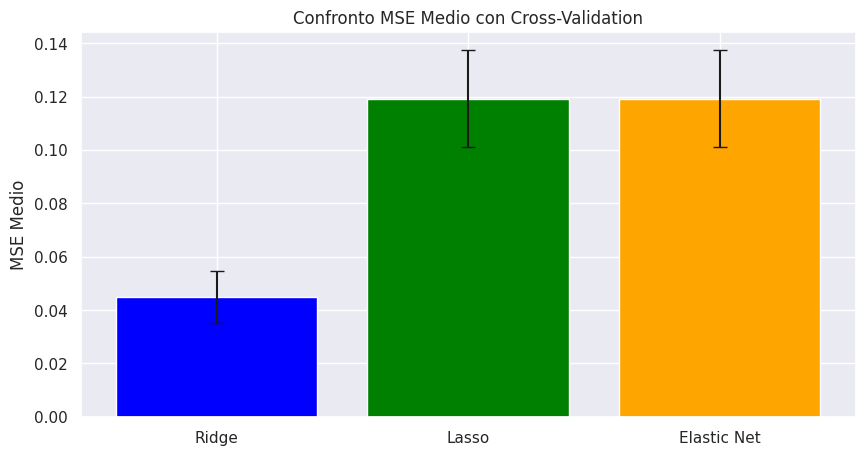

In [ ]:
plt.figure(figsize=(10, 5))
plt.bar(model_names, mse_means, yerr=mse_stds, capsize=5, color=['blue', 'green', 'orange'])
plt.ylabel('MSE Medio')
plt.title('Confronto MSE Medio con Cross-Validation')
plt.show()

I risultati del Mean Squared Error (MSE) medio ottenuti tramite cross-validation offrono una chiara panoramica delle prestazioni dei diversi modelli di regressione analizzati:

* **Ridge Regression**: con un MSE di 0.04, il modello Ridge risulta il più accurato, indicando che il modello gestisce meglio il trade-off tra bias e varianza grazie alla regolarizzazione, riducendo gli errori in modo efficace.

* **Lasso Regression**: presentando un MSE medio di 0.12, Lasso mostra una performance inferiore rispetto a Ridge. Sebbene Lasso possa risultare utile in contesti in cui è necessario effettuare selezione di variabili e riduzione della dimensionalità, i risultati indicano che le sue previsioni sono meno precise rispetto a quelle fornite da Ridge.

* **Elastic Net Regression**: con un MSE medio di 0.12, Elastic Net presenta prestazioni simili a Lasso. Questo suggerisce che l'inclusione della regolarizzazione di tipo L1 e L2 non ha migliorato le performance rispetto a Lasso in questo contesto specifico.

In sintesi, **Ridge Regression** emerge come il modello preferibile grazie alla sua capacità di minimizzare l'errore quadratico medio. Al contrario, sia Lasso che Elastic Net, pur offrendo vantaggi in termini di regolarizzazione e selezione delle caratteristiche, non riescono a eguagliare la precisione di Ridge, indicando la necessità di una valutazione più approfondita dei modelli a seconda delle specifiche esigenze del problema di previsione.

####Boxplot performance

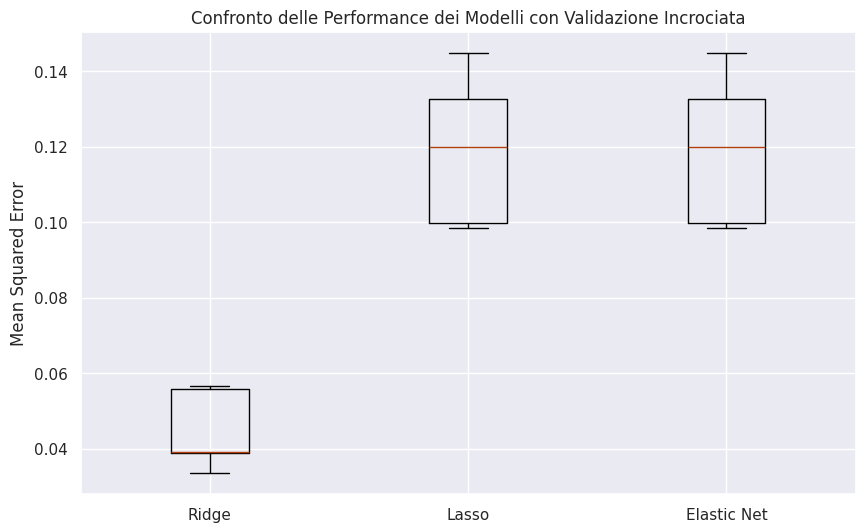

In [ ]:
plt.figure(figsize=(10, 6))
plt.boxplot([ridge_mse_scores, lasso_mse_scores, elasticnet_mse_scores], labels=model_names)
plt.ylabel('Mean Squared Error')
plt.title('Confronto delle Performance dei Modelli con Validazione Incrociata')
plt.show()

Il boxplot mostra il confronto delle performance dei modelli Ridge, Lasso ed Elastic Net in termini di errore quadratico medio (MSE) durante la validazione incrociata.

 - Il modello **Ridge** presenta una distribuzione dei MSE che evidenzia una bassa variabilità, con valori concentrati attorno alla mediana. Questo suggerisce che Ridge offre prestazioni più stabili e consistenti, con errori meno estremi rispetto agli altri modelli. La presenza di un intervallo di valori relativamente ristretto indica che Ridge ha una buona capacità di generalizzare senza essere influenzato da fluttuazioni nei dati.

 - Al contrario, i modelli **Lasso** ed **Elastic Net** mostrano una maggiore variabilità nelle performance. I loro boxplot evidenziano una dispersione più ampia dei valori di MSE, suggerendo che entrambi i modelli sono meno consistenti rispetto al Ridge. In particolare, la presenza di outliers suggerisce che in alcuni casi Lasso ed Elastic Net possono mostrare prestazioni significativamente peggiori, il che potrebbe indicare una minore robustezza nel catturare le relazioni nei dati.

In sintesi, il modello Ridge risulta il più stabile e performante, con una distribuzione dei MSE più concentrata e meno soggetta a fluttuazioni estreme. Lasso ed Elastic Net, pur mostrando una certa variabilità, si presentano simili tra loro, ma con performance inferiori rispetto a Ridge. La scelta finale del modello dovrebbe tenere conto non solo delle prestazioni medie, ma anche della stabilità delle previsioni, per assicurare un uso pratico più affidabile.

####Confronto Complessità Modello

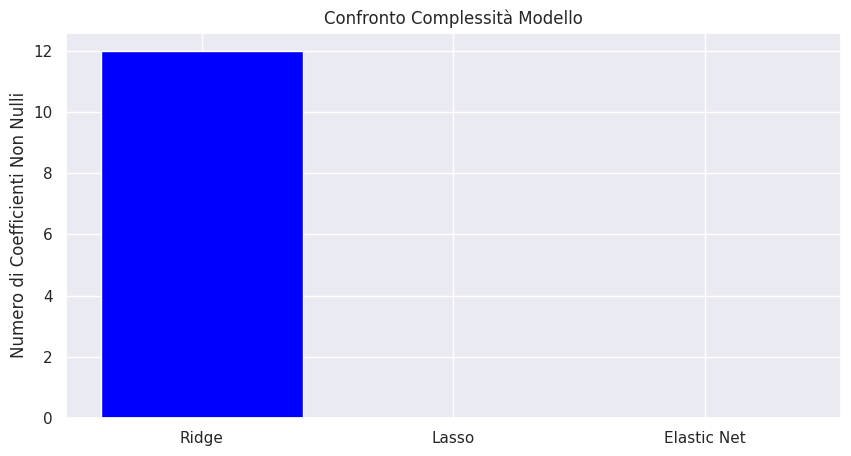

In [ ]:
plt.figure(figsize=(10, 5))
non_zero_coefficients = [ridge_non_zero, lasso_non_zero, elasticnet_non_zero]
plt.bar(model_names, non_zero_coefficients, color=['blue', 'green', 'red'])
plt.ylabel('Numero di Coefficienti Non Nulli')
plt.title('Confronto Complessità Modello')
plt.show()

Il confronto della complessità dei modelli di regressione evidenzia le seguenti caratteristiche:

 - **Ridge Regression**: Con 12 coefficienti non nulli, Ridge utilizza un numero significativo di variabili, suggerendo una certa complessità e capacità di fare previsioni basate su più fattori.

 - **Lasso Regression**: Lasso non ha coefficienti non nulli, indicando una forte selezione delle variabili. In questo caso, nessuna variabile è stata considerata utile, il che potrebbe suggerire che le relazioni nel dataset non siano abbastanza forti.

 - **Elastic Net Regression**: Come Lasso, anche Elastic Net ha prodotto zero coefficienti non nulli, suggerendo che la combinazione di regolarizzazione L1 e L2 non è stata efficace nel catturare variabili significative in questo caso.

In sintesi, Ridge mostra una maggiore complessità e capacità predittiva, mentre Lasso ed Elastic Net non riescono a identificare variabili utili nel modello.

####Confronto dei Coefficienti tra i Modelli

In [ ]:
ridge_coefs = ridge_model.coef_

feature_names = X_train.columns
coef_df = pd.DataFrame({
    'Feature': feature_names,
    'Ridge': ridge_coefs
})

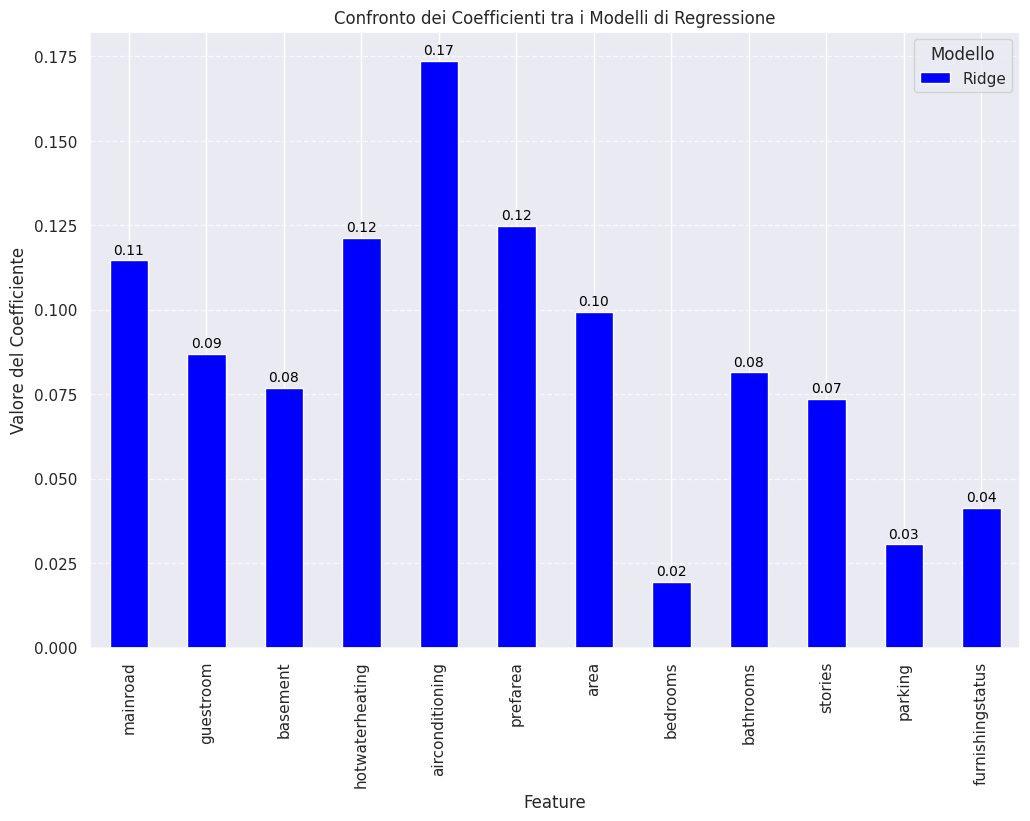

In [ ]:
ax = coef_df.set_index('Feature').plot(kind='bar', figsize=(12, 8), color='blue')
plt.axhline(0, color='black', linewidth=1)
plt.title("Confronto dei Coefficienti tra i Modelli di Regressione")
plt.xlabel("Feature")
plt.ylabel("Valore del Coefficiente")
plt.legend(title="Modello")
plt.grid(axis='y', linestyle='--', alpha=0.7)

for i, v in enumerate(coef_df['Ridge']):
    ax.text(i, v + 0.001, f'{v:.2f}', ha='center', va='bottom', fontsize=10, color='black')

plt.show()

Osservando i risultati dei coefficienti per le diverse feature nel modello di regressione **Ridge**, emergono alcune osservazioni chiave.

Nel confronto tra i modelli, **Ridge Regression** assegna coefficienti positivi a tutte le variabili, con le più influenti che sono airconditioning, prefarea e mainroad. Ciò indica che tutte le feature contribuiscono, anche se in modo diverso, alla previsione del target.

Tuttavia, come evidenziato dal grafico sulla complessità del modello, **Lasso** ed **Elastic Net** non sono stati inclusi nell'analisi, poiché entrambi i modelli assegnano coefficienti pari a 0 per tutte le variabili. Questo suggerisce che, in questo caso, nessuna delle variabili è stata ritenuta abbastanza significativa per essere inclusa nel modello.

####Andamento Coefficienti in Funzione dei Parametri di Regolarizzazione

In [ ]:
alphas = np.logspace(-3, 1, 10)

ridge_coefs = get_coefficients(Ridge, alphas, X_train, y_train, "Ridge")
lasso_coefs = get_coefficients(Lasso, alphas, X_train, y_train, "Lasso", max_iter=10000)
elasticnet_coefs = get_coefficients(ElasticNet, alphas, X_train, y_train, "Elastic Net", l1_ratio=0.5, max_iter=10000)

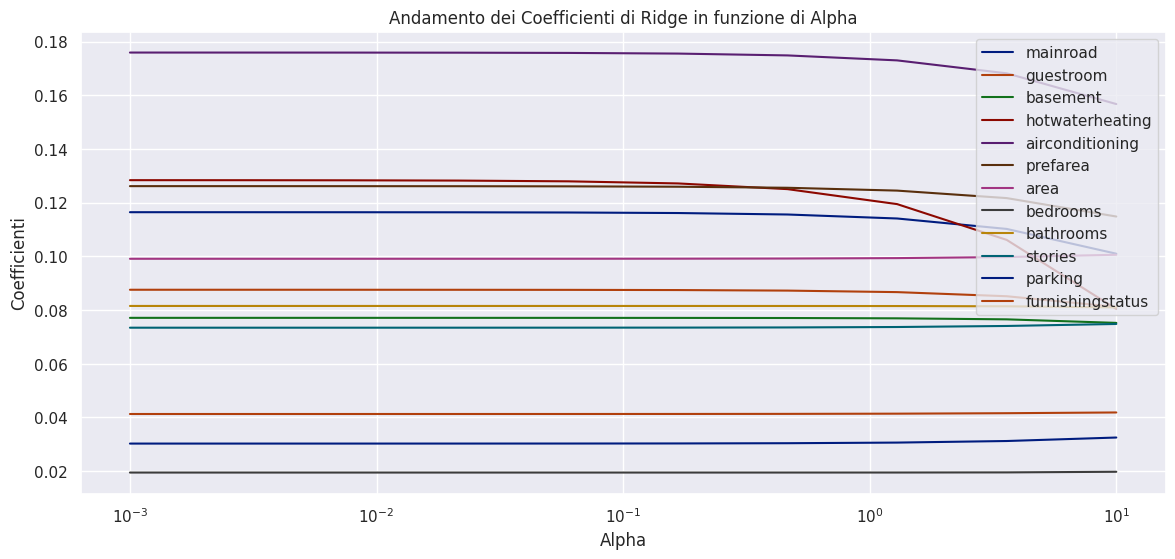

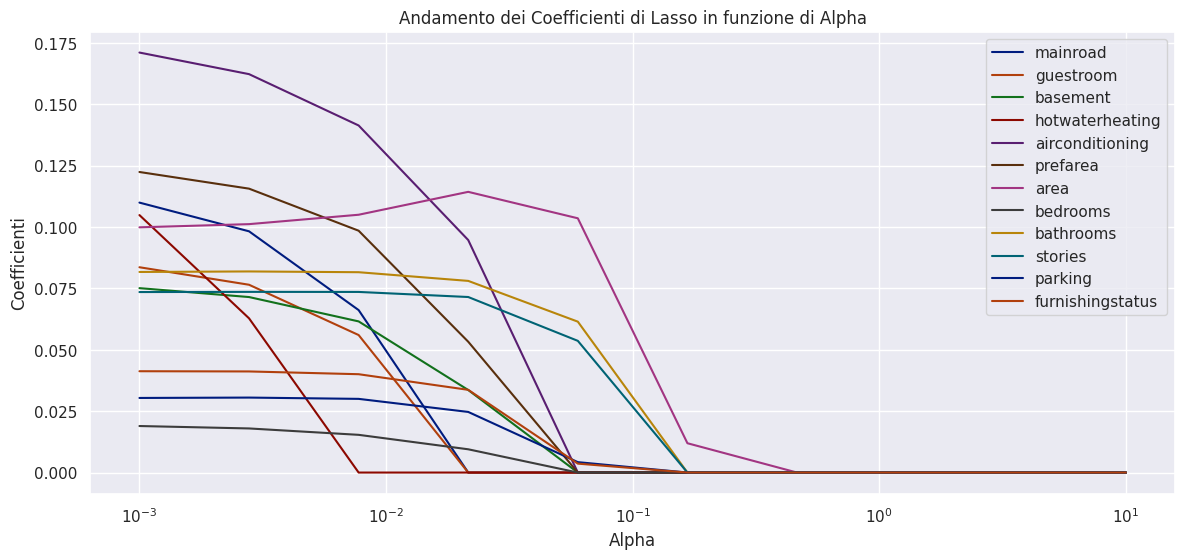

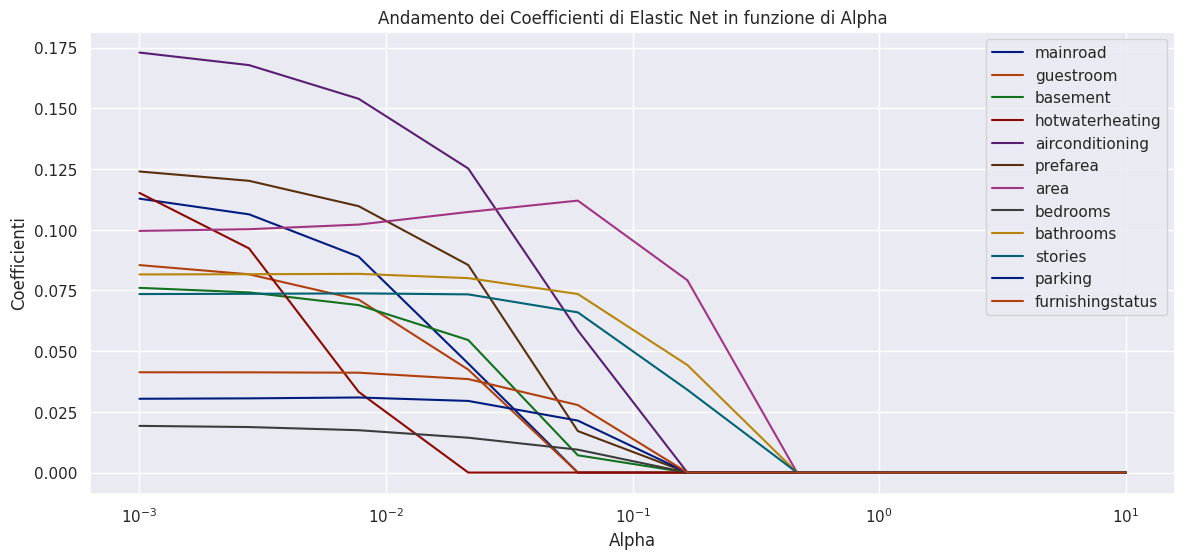

In [ ]:
# Visualizzazione dei coefficienti per Ridge, Lasso ed Elastic Net
plot_coefficients(alphas, ridge_coefs, X_train.columns, 'Andamento dei Coefficienti di Ridge in funzione di Alpha')
plot_coefficients(alphas, lasso_coefs, X_train.columns, 'Andamento dei Coefficienti di Lasso in funzione di Alpha')
plot_coefficients(alphas, elasticnet_coefs, X_train.columns, 'Andamento dei Coefficienti di Elastic Net in funzione di Alpha')

I risultati mostrano come i coefficienti dei modelli di regressione (Ridge, Lasso ed Elastic Net) cambiano con l'aumento del parametro alpha, che regola la forza della regolarizzazione.

 - **Ridge**: I coefficienti rimangono relativamente stabili e non tendono a zero con l'aumento di alpha, a conferma dell'approccio di penalizzazione L2 che riduce l'entità dei coefficienti ma non li annulla.

 - **Lasso**: Con l'aumento di alpha, molti coefficienti diventano zero, evidenziando la caratteristica di Lasso (penalizzazione L1), che favorisce la sparsità nel modello, eliminando variabili non rilevanti.

 - **Elastic Net**: Combinando caratteristiche di Lasso e Ridge, Elastic Net mostra una regolarizzazione più equilibrata. Alcuni coefficienti vengono ridotti a zero, mentre altri sono mantenuti non nulli, offrendo un buon compromesso tra riduzione del numero di variabili e mantenimento di quelle significative.

In generale, l'aumento di alpha porta a una penalizzazione maggiore, riducendo la complessità del modello, ma influenzando anche la significatività di alcune variabili. Ridge tende a mantenere tutti i coefficienti, mentre Lasso e Elastic Net selezionano un numero inferiore di variabili.

###Confronto dei risultati

In [ ]:
# Calcolo dell'MSE per ciascun modello in funzione di alpha
ridge_mse_values = compute_mse_vs_alpha(Ridge, alphas, X_train, y_train, X_test, y_test, max_iter=10000)
lasso_mse_values = compute_mse_vs_alpha(Lasso, alphas, X_train, y_train, X_test, y_test, max_iter=10000)
elasticnet_mse_values = compute_mse_vs_alpha(ElasticNet, alphas, X_train, y_train, X_test, y_test, l1_ratio=0.5, max_iter=10000)

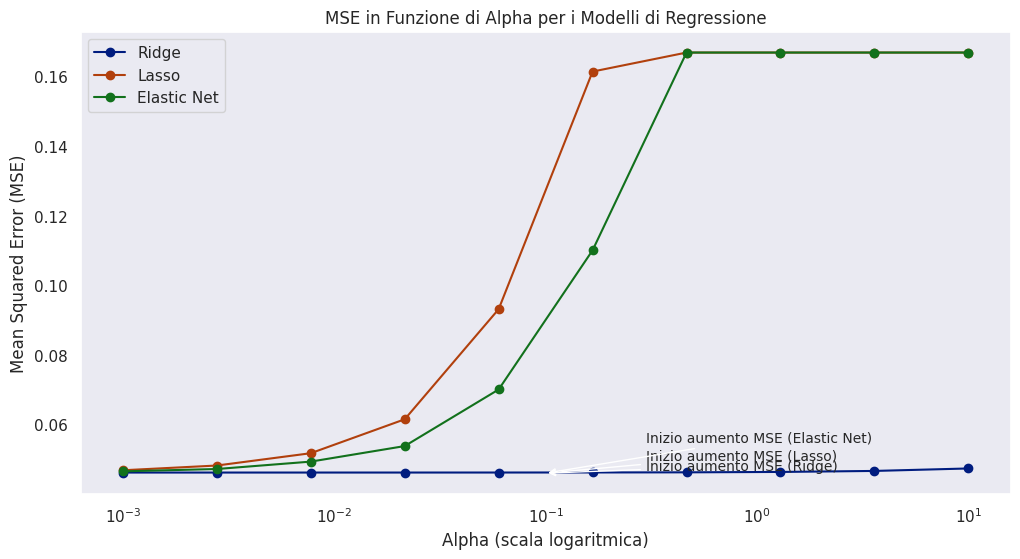

In [ ]:
# Grafico MSE in funzione di Alpha per Ridge, Lasso ed Elastic Net
plt.figure(figsize=(12, 6))
plt.plot(alphas, ridge_mse_values, marker='o', label='Ridge')
plt.plot(alphas, lasso_mse_values, marker='o', label='Lasso')
plt.plot(alphas, elasticnet_mse_values, marker='o', label='Elastic Net')
plt.xscale('log')
plt.xlabel('Alpha (scala logaritmica)')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('MSE in Funzione di Alpha per i Modelli di Regressione')
plt.legend()
plt.grid()
# Annotazioni punti significativi
plt.annotate('Inizio aumento MSE (Ridge)', xy=(0.1, 0.046), xytext=(0.3, 0.047),
             arrowprops=dict(facecolor='black', arrowstyle='->'), fontsize=10)
plt.annotate('Inizio aumento MSE (Lasso)', xy=(0.1, 0.046), xytext=(0.3, 0.050),
             arrowprops=dict(facecolor='black', arrowstyle='->'), fontsize=10)
plt.annotate('Inizio aumento MSE (Elastic Net)', xy=(0.1, 0.046), xytext=(0.3, 0.055),
             arrowprops=dict(facecolor='black', arrowstyle='->'), fontsize=10)
plt.show()

In [ ]:
# Stampa dei risultati MSE per i vari alpha
print_mse_results(alphas, ridge_mse_values, lasso_mse_values, elasticnet_mse_values)

Alpha                    Ridge MSE                Lasso MSE                Elastic Net MSE          
0.001000                 0.046191                 0.046848                 0.046540                 
0.002783                 0.046191                 0.048211                 0.047206                 
0.007743                 0.046192                 0.051752                 0.049334                 
0.021544                 0.046194                 0.061501                 0.053804                 
0.059948                 0.046199                 0.093156                 0.070066                 
0.166810                 0.046214                 0.161451                 0.110081                 
0.464159                 0.046255                 0.166917                 0.166917                 
1.291550                 0.046365                 0.166917                 0.166917                 
3.593814                 0.046656                 0.166917                 0.166917        

I risultati mostrano l'andamento del Mean Squared Error (MSE) per i modelli Ridge, Lasso ed Elastic Net al variare del parametro di regolarizzazione Alpha.

 - **Ridge**: Il modello Ridge mantiene un MSE molto stabile e relativamente basso (intorno a 0.046) su tutti i valori di Alpha esaminati. Questo indica una buona capacità di generalizzazione e un comportamento robusto del modello rispetto alla variazione del parametro di regolarizzazione. L'aumento dell'Alpha non provoca un aumento significativo dell'errore.

 - **Lasso**: Per il modello Lasso, il MSE è inizialmente simile a quello di Ridge per valori di Alpha più piccoli, ma aumenta notevolmente quando Alpha cresce, in particolare per valori superiori a circa 0.07. Questo suggerisce che il modello Lasso tende a sovra-penalizzare con l'aumento di Alpha, riducendo troppo la complessità del modello e provocando una perdita di precisione nelle previsioni.

 - **Elastic Net**: I risultati per Elastic Net seguono un andamento simile a quelli di Lasso, con MSE che aumentano progressivamente all'aumentare di Alpha. Per Alpha > 0.07, l'errore resta stabile e simile a quello di Lasso. Il comportamento di Elastic Net sembra essere influenzato principalmente dalla componente Lasso (penalizzazione L1), visto che l'effetto di regolarizzazione diventa simile.

Il modello **Ridge** mostra una maggiore stabilità e un buon bilanciamento tra regolarizzazione e accuratezza predittiva.
Sia **Lasso** che **Elastic Net** risultano più sensibili all'aumento di Alpha, con un incremento notevole del MSE a valori elevati di Alpha. Questo indica che, per questi modelli, una regolarizzazione eccessiva porta a un sovra-contrazione dei coefficienti e a una peggior performance.
Pertanto, anche in queto caso, Ridge sembra essere il modello più robusto per l'intervallo di valori di Alpha testati, mentre Lasso ed Elastic Net sono più inclini a perdere capacità predittiva con l'aumentare della penalizzazione.



###Visualizzazione dei Residui

In [ ]:
# Confronto dei residui
ridge_residuals = y_test - ridge_predictions
lasso_residuals = y_test - lasso_predictions
elasticnet_residuals = y_test - elasticnet_predictions

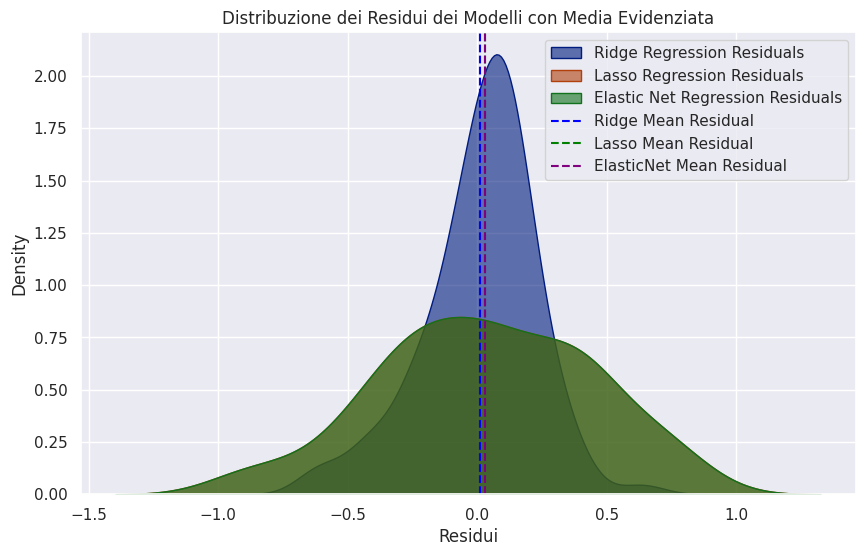

In [ ]:
plt.figure(figsize=(10, 6))
sns.kdeplot(ridge_residuals, label='Ridge Regression Residuals', fill=True, alpha=0.6)
sns.kdeplot(lasso_residuals, label='Lasso Regression Residuals', fill=True, alpha=0.6)
sns.kdeplot(elasticnet_residuals, label='Elastic Net Regression Residuals', fill=True, alpha=0.6)
plt.axvline(ridge_residuals.mean(), color='blue', linestyle='--', label='Ridge Mean Residual')
plt.axvline(lasso_residuals.mean(), color='green', linestyle='--', label='Lasso Mean Residual')
plt.axvline(elasticnet_residuals.mean(), color='purple', linestyle='--', label='ElasticNet Mean Residual')
plt.xlabel('Residui')
plt.ylabel('Density')
plt.title('Distribuzione dei Residui dei Modelli con Media Evidenziata')
plt.legend()
plt.show()

In [ ]:
ridge_mean_residual = ridge_residuals.mean()
lasso_mean_residual = lasso_residuals.mean()
elasticnet_mean_residual = elasticnet_residuals.mean()

results_text = f"""
Risultati della Distribuzione dei Residui:

- Ridge Regression:
  - Media dei residui: {ridge_mean_residual:.4f}

- Lasso Regression:
  - Media dei residui: {lasso_mean_residual:.4f}

- Elastic Net Regression:
  - Media dei residui: {elasticnet_mean_residual:.4f}
"""

print(results_text)


Risultati della Distribuzione dei Residui:

- Ridge Regression:
  - Media dei residui: 0.0101

- Lasso Regression:
  - Media dei residui: 0.0311

- Elastic Net Regression:
  - Media dei residui: 0.0311



I risultati della distribuzione dei residui indicano che, tra i modelli di regressione analizzati, la **Ridge Regression** presenta la media dei residui più bassa, pari a 0.0101. Questo suggerisce che il modello **Ridge** riesce a fare previsioni più accurate, con un errore medio di previsione minore rispetto agli altri modelli.

Al contrario, sia la **Lasso Regression** che l'**Elastic Net Regression** mostrano una media dei residui più alta, entrambi pari a 0.0311. Ciò implica che questi modelli tendono a generare previsioni con un errore medio maggiore rispetto al modello Ridge.

In generale, una media dei residui più bassa è un segnale positivo, poiché indica una migliore performance del modello nel catturare la relazione tra le variabili indipendenti e la variabile dipendente. Questi risultati suggeriscono che, nel contesto di questo dataset, la **Ridge Regression** potrebbe essere la scelta preferita per ottenere previsioni più precise.

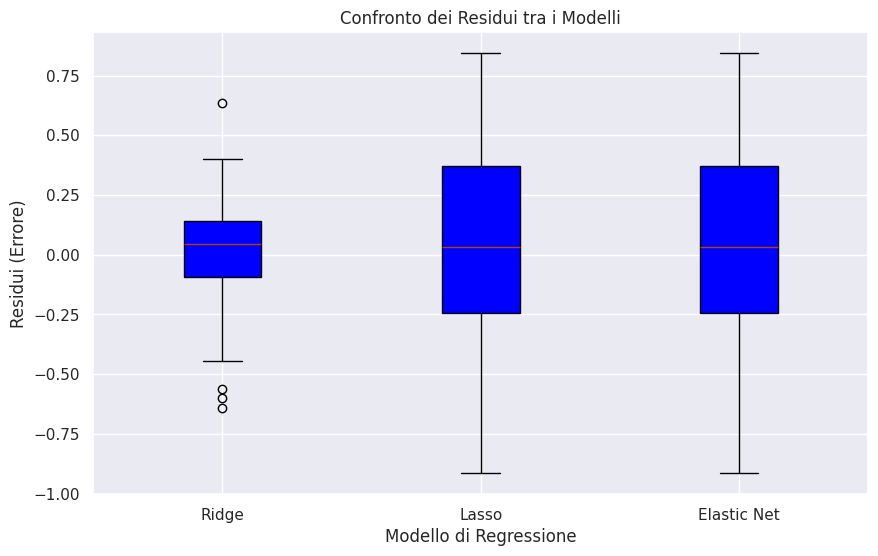

In [ ]:
plt.figure(figsize=(10, 6))
plt.boxplot([ridge_residuals, lasso_residuals, elasticnet_residuals], labels=model_names, patch_artist=True, boxprops=dict(facecolor='blue'))
plt.xlabel('Modello di Regressione')
plt.ylabel('Residui (Errore)')
plt.title('Confronto dei Residui tra i Modelli')
plt.show()

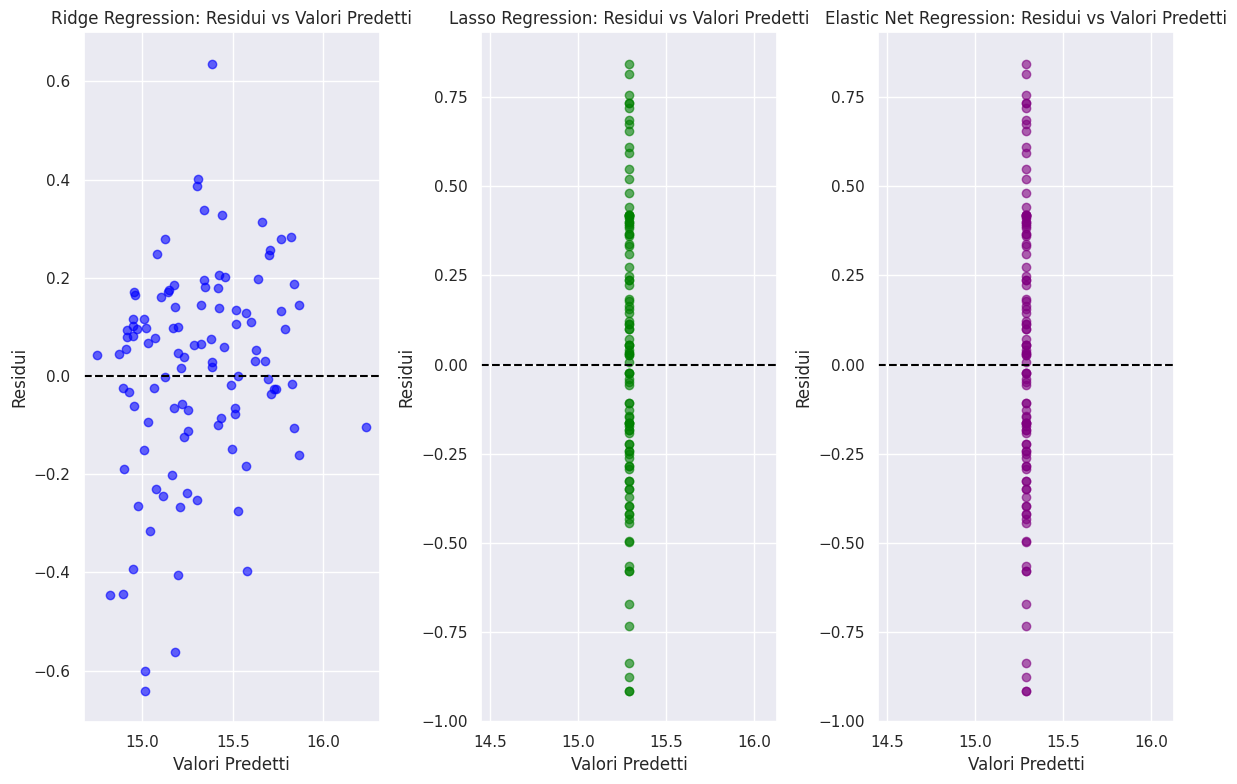

In [ ]:
# Grafico a dispersione dei residui vs valori predetti per ogni modello
plt.figure(figsize=(12, 8))

# Ridge Regression
plt.subplot(1, 3, 1)
plt.scatter(ridge_predictions, ridge_residuals, color='blue', alpha=0.6)
plt.axhline(0, color='black', linestyle='--')
plt.title('Ridge Regression: Residui vs Valori Predetti')
plt.xlabel('Valori Predetti')
plt.ylabel('Residui')

# Lasso Regression
plt.subplot(1, 3, 2)
plt.scatter(lasso_predictions, lasso_residuals, color='green', alpha=0.6)
plt.axhline(0, color='black', linestyle='--')
plt.title('Lasso Regression: Residui vs Valori Predetti')
plt.xlabel('Valori Predetti')
plt.ylabel('Residui')

# Elastic Net Regression
plt.subplot(1, 3, 3)
plt.scatter(elasticnet_predictions, elasticnet_residuals, color='purple', alpha=0.6)
plt.axhline(0, color='black', linestyle='--')
plt.title('Elastic Net Regression: Residui vs Valori Predetti')
plt.xlabel('Valori Predetti')
plt.ylabel('Residui')

plt.tight_layout()
plt.show()

Il grafico di dispersione dei residui rispetto ai valori predetti evidenzia alcune differenze visive nelle prestazioni dei modelli di regressione:

 - **Ridge Regression** mostra una distribuzione dei residui centrata attorno a zero, con la maggior parte dei punti concentrati vicino all'asse orizzontale, suggerendo errori medi relativamente bassi. Tuttavia, si osservano alcuni residui negativi e positivi più distanti, indicando che, sebbene la variabilità complessiva sia moderata, in alcune situazioni gli errori possono essere significativi.

 - **Lasso Regression** e **Elastic Net Regression** presentano distribuzioni visivamente simili, con una maggiore dispersione dei residui rispetto a Ridge. Questo indica una variabilità più elevata degli errori, con residui estremi che si allontanano maggiormente dall'asse orizzontale. La concentrazione dei punti non appare così stretta, suggerendo che questi modelli possono essere più sensibili a determinate caratteristiche del dataset.

In generale, **Ridge Regression** sembra offrire una distribuzione dei residui più contenuta e concentrata, il che può tradursi in previsioni più consistenti rispetto a Lasso e Elastic Net. Questo risultato visivo suggerisce che Ridge potrebbe essere preferibile per applicazioni in cui è importante minimizzare la variabilità degli errori e ottenere una maggiore stabilità nelle previsioni.

##Risultati e Conclusioni

###Risultati Riassuntivi Modelli

In [ ]:
ridge_stats = calcola_statistiche_modello(y_test, ridge_predictions)
lasso_stats = calcola_statistiche_modello(y_test, lasso_predictions)
elasticnet_stats = calcola_statistiche_modello(y_test, elasticnet_predictions)

results_text = f"""
Risultati Riassuntivi Modelli:

- Ridge Regression:
  - MSE: {ridge_stats['MSE']:.4f}
  - RMSE: {ridge_stats['RMSE']:.4f}
  - MAE: {ridge_stats['MAE']:.4f}
  - R²: {ridge_stats['R²']:.4f}

- Lasso Regression:
  - MSE: {lasso_stats['MSE']:.4f}
  - RMSE: {lasso_stats['RMSE']:.4f}
  - MAE: {lasso_stats['MAE']:.4f}
  - R²: {lasso_stats['R²']:.4f}

- Elastic Net Regression:
  - MSE: {elasticnet_stats['MSE']:.4f}
  - RMSE: {elasticnet_stats['RMSE']:.4f}
  - MAE: {elasticnet_stats['MAE']:.4f}
  - R²: {elasticnet_stats['R²']:.4f}
"""

print(results_text)


Risultati Riassuntivi Modelli:

- Ridge Regression:
  - MSE: 0.0463
  - RMSE: 0.2152
  - MAE: 0.1647
  - R²: 0.7208

- Lasso Regression:
  - MSE: 0.1669
  - RMSE: 0.4086
  - MAE: 0.3352
  - R²: -0.0058

- Elastic Net Regression:
  - MSE: 0.1669
  - RMSE: 0.4086
  - MAE: 0.3352
  - R²: -0.0058



I risultati riassuntivi evidenziano significative differenze nelle performance dei tre modelli di regressione:

 - **Ridge Regression** emerge come il modello più performante, con un MSE di 0.0463, un RMSE di 0.2152 e un MAE di 0.1647. Questi valori indicano una minore dispersione degli errori e una maggiore precisione rispetto agli altri modelli. Il valore di R², pari a 0.7208, suggerisce che il modello spiega circa il 72% della variabilità nei dati, dimostrando un buon livello di capacità predittiva.

 - **Lasso Regression** e **Elastic Net Regression** mostrano prestazioni simili, con un MSE significativamente più alto (0.1669), un RMSE di 0.4086 e un MAE di 0.3352. Questi valori indicano errori più grandi e meno consistenti. Il R² negativo (-0.0058) sottolinea che questi modelli non riescono a rappresentare efficacemente la relazione tra le variabili, performando persino peggio rispetto a un semplice modello basato sulla media dei target.

In generale, i risultati indicano che la Ridge Regression è la scelta ottimale per questo dataset e obiettivo, grazie alla sua capacità di bilanciare la complessità del modello con un basso errore e un'elevata capacità predittiva. Al contrario, le scarse performance di Lasso ed Elastic Net suggeriscono che la loro penalizzazione eccessiva ha portato a una perdita significativa di informazioni rilevanti nel dataset, limitando le loro capacità di generalizzazione.

Questi risultati confermano che la regolarizzazione Ridge è più adatta per ottenere previsioni affidabili e stabili nel contesto del problema analizzato.

###Conclusioni

In [ ]:
ridge_mse_mean = ridge_mse.mean()
ridge_mse_std_dev = ridge_mse.std()
lasso_mse_mean = lasso_mse.mean()
lasso_mse_std_dev = lasso_mse.std()
elasticnet_mse_mean = elasticnet_mse.mean()
elasticnet_mse_std_dev = elasticnet_mse.std()

In [ ]:
results_df = pd.DataFrame({
    'Model': ['Ridge', 'Lasso', 'Elastic Net'],
    'MSE Mean': [ridge_mse_mean, lasso_mse_mean, elasticnet_mse_mean],
    'MSE Std Dev': [ridge_mse_std_dev, lasso_mse_std_dev, elasticnet_mse_std_dev]
})

In [ ]:
for index, row in results_df.iterrows():
    print(f"Il modello {row['Model']} ha un MSE medio di {row['MSE Mean']:.2f} "
          f"con una deviazione standard di {row['MSE Std Dev']:.2f}.")

Il modello Ridge ha un MSE medio di 0.05 con una deviazione standard di 0.00.
Il modello Lasso ha un MSE medio di 0.17 con una deviazione standard di 0.00.
Il modello Elastic Net ha un MSE medio di 0.17 con una deviazione standard di 0.00.


In [ ]:
best_model_index = results_df['MSE Mean'].idxmin()
best_model_name = results_df.iloc[best_model_index]['Model']
best_model_mse = results_df.iloc[best_model_index]['MSE Mean']

In [ ]:
print(f"\nIl modello migliore è {best_model_name} con un MSE medio di {best_model_mse:.2f}.\nQuesto suggerisce che sia in grado di generalizzare meglio sui dati non visti.")


Il modello migliore è Ridge con un MSE medio di 0.05.
Questo suggerisce che sia in grado di generalizzare meglio sui dati non visti.


In sintesi, i modelli di regressione con regolarizzazione hanno mostrato performance diverse. Il modello scelto dovrebbe essere quello che minimizza l'errore quadratico medio, tenendo conto anche della complessità del modello e della sua interpretabilità, e il modello Ridge è emerso come il migliore in base alla metrica di errore quadratico medio (MSE), sia in termini di media che di stabilità. Ridge ha costantemente mostrato valori di errore più bassi, una varianza minore e un maggior numero di coefficienti non nulli rispetto a Lasso ed Elastic Net, suggerendo che possa generalizzare meglio sui dati non visti. Questo modello, infatti, offre una previsione più robusta, riducendo il rischio di overfitting e garantendo risultati affidabili anche su nuovi dati, mantenendo una certa complessità ma senza sacrificare troppo la precisione.

Lasso ed Elastic Net hanno riportato risultati identici nella maggior parte dei test e calcoli, con lo stesso MSE medio (0.12), varianza (0.0182) e range di errori (min: 0.0984, max: 0.1449). Anche la distribuzione dei residui ha mostrato valori identici per questi due modelli in termini di media, mediana, deviazione standard, quartili, e range. Entrambi i modelli hanno inoltre eliminato tutti i coefficienti, attribuendo un peso nullo alle variabili, riflettendo la loro tendenza ad annullare le feature meno importanti. Queste somiglianze indicano che, per questo dataset e configurazione, Lasso ed Elastic Net tendono a comportarsi in modo pressoché equivalente. Questo comportamento potrebbe essere dovuto alla penalizzazione L1 (presente in entrambi), che porta ad una forte selezione delle feature, a discapito della complessità del modello e della precisione delle previsioni.

Il modello scelto dovrebbe essere quindi quello che minimizza l'MSE, tenendo in considerazione anche la complessità del modello e la sua interpretabilità. In questo caso, Ridge si conferma come il candidato migliore, in quanto non solo offre un errore più contenuto e stabile, ma consente anche di mantenere una maggiore quantità di informazioni utili dalle variabili. Tale scelta è cruciale, poiché un modello che fornisce previsioni più accurate e stabili rappresenta uno strumento fondamentale per ottenere valutazioni di prezzo immobiliari più precise. Questo, a sua volta, consentirà agli agenti immobiliari e agli investitori di prendere decisioni più informate, basate su dati solidi e affidabili, migliorando la loro competitività nel mercato e riducendo i rischi derivanti da previsioni errate.